# Cascaded Integrator–Comb (CIC) Filter

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from rfproto import measurements, multirate, plot, sig_gen

Benefits:
* Multiplier-free implementation for economical (light resource utilization) design in digital HW systems which can handle arbitrary, and large, rate changes.
* High interpolation CIC filters can push very narrowband signals (e.x. TT&C ~2MS/s max) go to sufficient ADC/DAC sample rates (e.x. 125MS/s)
* Data reduction to not have to pass as much data to/from the front end (e.g. having to push full sample bandwidth data to/from a remote radio head)

CIC filters can be used as decimation (decrease sample rate) and interpolation (increase sample rate) multirate filters:

<div style="text-align:center;">
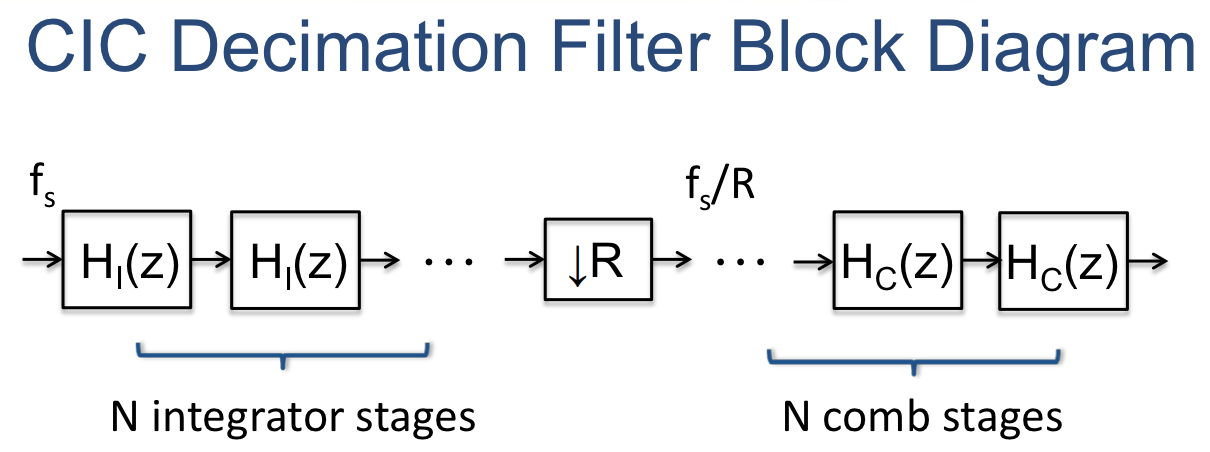
</div>

<div style="text-align:center;">
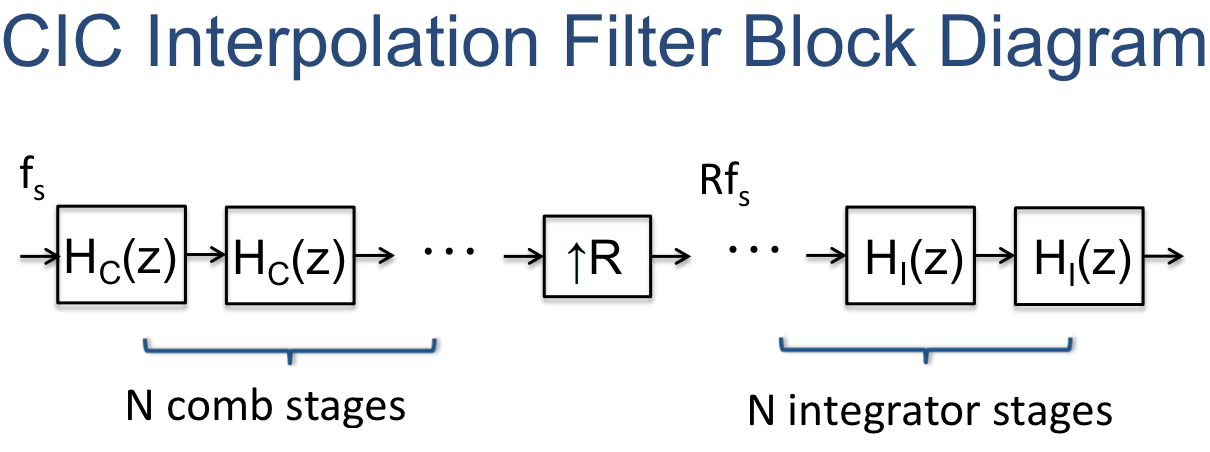
</div>

The basic building blocks are $N$ _integrator_ and $N$ _comb_ sections (hence the name), along with an interpolator (e.g. zero-stuffing expander) or decimator, increasing or decreasing the output sample rate by $R$ times (respectively).

## Integrator Section

An integrator is simply a single-pole IIR filter with unity feedback coefficient:
$$y[n] = y[n-1] + x[n]$$

This is also commonly known as an accumulator, which has the $z$-transform transfer function of:
$$H_{I}(z)=\frac{1}{1 - z^{-1}}$$

> The power response is basically a low-pass filter with a −20 dB per decade (−6 dB per
octave) rolloff, but with infinite gain at DC. This is due to the single pole at z = 1; the
output can grow without bound for a bounded input. In other words, a single integrator by
itself is unstable. - [CIC Filter Introduction - Matthew P. Donadio (DSP Guru)](http://dspguru.com/files/cic.pdf)

<div style="text-align:center;">
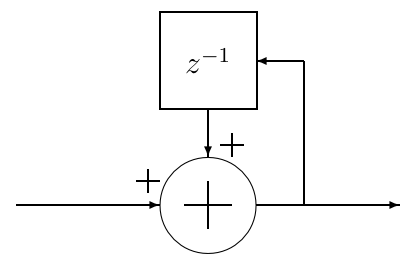
</div>

Note the pipelined version of the integrator which allows for more efficient digital hardware implementation (only one added between register stages):

<div style="text-align:center;">
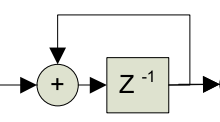
</div>

## Comb Section

The comb filter runs at the highest sample rate, $f_{C} = R*f_{I}$, in either decimation or interpolation filter form. It looks opposite of an integrator section as it subtracts the current sample value from a value $M$ sample periods prior; $M$ is the _differential delay_ design parameter, and is often limited to $M = 1$ or $M = 2$:
$$y[n] = x[n] - x[n - RM]$$

The corresponding transfer function at $f_{s}$ is:
$$H_{C}(z) = 1 - z^{-RM}$$

When $R=1$ and $M=1$, the power response is a high-pass function with 20dB per decade gain (inverse of the integrator response). When $RM \neq 1$, the power response looks like a familiar raised cosince form with $RM$ cycles from $0 \rightarrow 2\pi$.

<div style="text-align:center;">
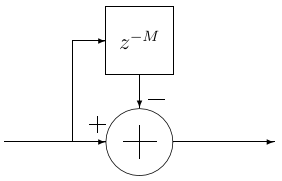
</div>

<div style="text-align:center;">
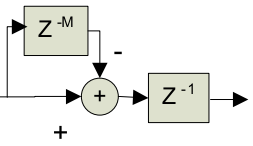
</div>

## Bit Growth

Due to the cascaded adders/subtracters in the CIC filter, each fixed-point, two's complement arithmetic operation requires an additional bit of output than input, to prevent loss of precision. Given an input sample bitwidth of $B_{in}$, the output bitwidth required can be found to be:
$$B_{out} = \lceil N\log_{2}RM + B_{in} \rceil$$

At the expense of [added quantization noise](https://www.dsprelated.com/showthread/comp.dsp/65321-1.php), bit growth can be controlled by rounding/scaling at some points within the CIC stages.

`#TODO:`
* [ ] Look at the fred harris paper on multiplier-less CIC with sharpening that doesn’t need compensation FIR
  + Also mentioned in https://www.dsprelated.com/showarticle/1337.php
* [ ] For bit growth, look at [CIC filter register pruning](https://www.dsprelated.com/showcode/269.php)
  + Also shown in http://www.jks.com/cic/cic.html and https://github.com/jks-prv/cic_prune

## Discrete-Time Test of CIC

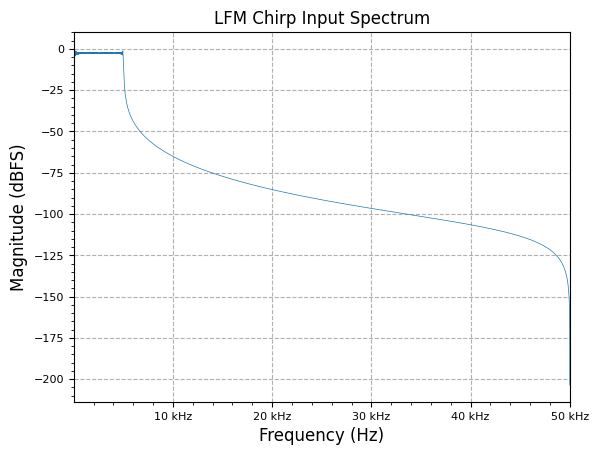

In [2]:
f_start = 0
f_end = 5e3
fs = 100e3
num_samples = 100000
bit_width = 16

lfm_chirp_sig = np.real(sig_gen.cmplx_dt_lfm_chirp(2**(bit_width-5), f_start, f_end, fs, num_samples))
freq, y_PSD = measurements.PSD(lfm_chirp_sig, fs, real=True, norm=True)
plot.freq_sig(freq, y_PSD, "LFM Chirp Input Spectrum", scale_noise=False)
plt.show()

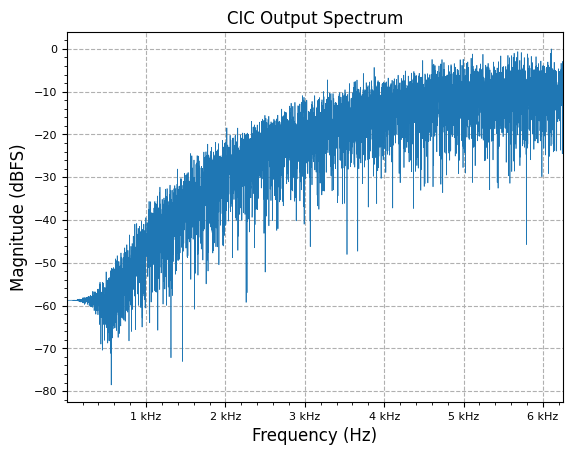

In [3]:
N = 3 # number of stages
R = 8 # interp/decim factor
M = 1 # differential delay in comb stages

cic_bit_width = 21 # np.ceil(N * np.log2(R*M) + bit_width)

integ_stages = [multirate.integrator(cic_bit_width) for i in range(N)]
comb_stages = [multirate.comb(M) for i in range(N)]

integ_out = np.zeros(len(lfm_chirp_sig))
for i in range(len(integ_out)):
    temp_val = int(lfm_chirp_sig[i])
    for j in range(N):
        temp_val = integ_stages[j].step(temp_val)
    integ_out[i] = temp_val

decimate_out = multirate.decimate(integ_out, R)

cic_out = np.zeros(len(decimate_out))
for i in range(len(cic_out)):
    temp_val = decimate_out[i]
    for j in range(N):
        temp_val = comb_stages[j].step(temp_val)
    cic_out[i] = temp_val

freq, y_PSD = measurements.PSD(cic_out, fs / R, real=True, norm=True)
plot.freq_sig(freq, y_PSD, "CIC Output Spectrum", scale_noise=False)
plt.show()

## References
* [CIC Filter Introduction - Matthew P. Donadio (DSP Guru)](http://dspguru.com/files/cic.pdf)
  + * [CIC Filter Introduction - DSP Guru](http://dspguru.com/dsp/tutorials/cic-filter-introduction/)
* [A Beginner's Guide to Cascaded Integrator-Comb (CIC) Filters](https://www.dsprelated.com/showarticle/1337.php)
* [Small Tutorial on CIC Filters](http://www.tsdconseil.fr/log/scriptscilab/cic/cic-en.pdf)
* [CIC Filter - Wikipedia](https://en.wikipedia.org/wiki/Cascaded_integrator%E2%80%93comb_filter)
* [CIC Compiler v4.0 - Xilinx](https://docs.xilinx.com/v/u/en-US/pg140-cic-compiler)
* [CIC Filter - OpenCores](https://opencores.org/projects/cic_core)